Load packages

In [157]:
import numpy as np 
import pandas as pd 
from scipy import stats

# pandas options
pd.set_option('display.max_columns', 60)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set() # use Seaborn styles
sns.color_palette("Blues")
plt.style.use('fivethirtyeight')


from sklearn import preprocessing, metrics
from sklearn.model_selection import cross_val_score, train_test_split, KFold, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.svm import SVR

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LinearRegression, Ridge


# import xgboost as xgb

import warnings; warnings.simplefilter('ignore')




In [158]:

# Data import
df = pd.read_csv('../2019_ratings_stats.csv')

In [159]:
df.head(5)

,name,team,position,height,brand,all_star,injured,two_way,rookie,rating,Pos,Age,Tm,G,GS,MPG,FG,FGA,FG.pct,3P,3PA,3P.pct,2P,2PA,2P.pct,eFG.pct,FT,FTA,FT.pct,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,MP_Total,PER,TS.pct,3PAr,FTr,ORB.pct,DRB.pct,TRB.pct,AST.pct,STL.pct,BLK.pct,TOV.pct,USG.pct,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Kent Bazemore,Atlanta Hawks,SG\n,"6""5'",Under Armour,0,0,0,0,76,SG,28,ATL,65,65,27.50,4.40,10.40,0.42,1.70,4.20,0.39,2.70,6.20,0.44,0.50,2.50,3.10,0.80,0.40,3.40,3.80,3.50,1.50,0.70,2.40,2.30,12.90,1789,14.50,0.55,0.41,0.30,1.60,13.90,7.70,20.10,2.70,2.20,17.00,22.50,0.20,2.00,2.20,0.06,-0.40,1.00,0.60,1.20
1,Dewayne Dedmon,Atlanta Hawks,C\n,"7""0'",Jordan,0,0,0,0,77,C,28,ATL,62,46,24.90,4.00,7.70,0.52,0.80,2.30,0.35,3.20,5.40,0.59,0.58,1.10,1.40,0.78,1.60,6.30,7.90,1.50,0.60,0.80,1.40,2.60,10.00,1542,15.80,0.60,0.30,0.18,7.20,28.10,17.70,9.20,1.30,2.80,14.30,17.00,1.80,1.90,3.70,0.11,-0.40,0.50,0.10,0.80
2,John Collins,Atlanta Hawks,PF\n,"6""10'",Adidas,0,0,0,0,84,PF,20,ATL,74,26,24.10,4.20,7.40,0.58,0.20,0.60,0.34,4.00,6.70,0.60,0.59,1.80,2.50,0.71,2.40,4.90,7.30,1.30,0.60,1.10,1.40,2.90,10.50,1785,18.30,0.62,0.09,0.34,11.00,22.80,16.90,8.90,1.30,3.80,14.30,17.90,3.40,2.00,5.40,0.14,-0.40,0.20,-0.20,0.80
3,Miles Plumlee,Atlanta Hawks,C\n,"6""11'",Peak,0,0,0,0,71,C,29,ATL,55,35,16.70,1.90,3.30,0.58,0.00,0.00,nan,1.90,3.30,0.58,0.58,0.50,1.10,0.45,1.40,2.70,4.10,0.80,0.30,0.50,1.10,1.40,4.30,918,10.60,0.57,0.00,0.33,9.40,18.30,13.90,7.20,0.90,2.80,23.40,12.80,0.10,0.70,0.90,0.05,-3.70,-0.10,-3.80,-0.40
4,Justin Anderson,Atlanta Hawks,SF\n,"6""6'",Nike,0,0,0,0,72,SF,24,PHI,38,0,13.70,2.30,5.30,0.43,0.90,2.70,0.33,1.40,2.60,0.54,0.52,0.70,1.00,0.74,0.70,1.80,2.40,0.70,0.40,0.20,0.40,1.40,6.20,519,13.00,0.54,0.51,0.19,5.40,13.60,9.60,7.10,1.40,1.10,6.80,19.30,0.60,0.70,1.20,0.12,-0.60,-0.30,-0.90,0.10


In [160]:
df.shape

(397, 59)

# Data cleaning

----

All steps that need to be performed in order to give the input data an adecuate format that allows us to do a first EDA. 

Examples of cleaning tasks: correct wrongly captured variables, setting NA values (those values that aren't NA but should be), ... 

### Clean position variable

In [161]:
# clean position variable
df.position = df.position.apply(lambda x: x.replace('\n', ''))

In [162]:
# drop b-ref position (interested in nba2k position) and rookie status (need to first fetch stats for rookies)
df = df.drop(['Pos', 'rookie'], axis = 1)


### Convert feet to cm

In [163]:
# convert feet to cm

# h_inch += h_ft * 12
# h_cm = round(h_inch * 2.54, 1)

def convert_row(row):
    empty_dict = {}
    # extract feet and inch for each row
    feet = int(row.height.split('\"')[0].replace('\'', ''))
    inches = int(row.height.split('\"')[1].replace('\'', ''))
    empty_dict['feet'] = feet
    empty_dict['inches'] = inches
    new_row = row.append(pd.Series(empty_dict))    
    return new_row

convert_row(df.iloc[0])

# apply to whole df
df = df.apply(lambda row: convert_row(row), axis = 1)


### ADD conversor to cm

In [164]:
# drop some features
df = df.drop(['name', 'position',  'team', 'height'], axis = 1)

# fill some NA values in the pct columns --- this should go in the preprocessing part
df = df.fillna(0)

# convert to integer
to_int=['G','GS','rating', 'Age', 'MP_Total']

for var in to_int:
      df[var] = df[var].apply(lambda x: int(x))
  
# convert to float
  
to_float = ['MPG',	'FG',	'FGA',	'FG.pct',	'3P',	'3PA',	'3P.pct',	'2P',
            '2PA',	'2P.pct',	'eFG.pct',	'FT',	'FTA',	'FT.pct',	'ORB',	'DRB',	'TRB',
            'AST',	'STL',	'BLK',	'TOV',	'PF',	'PTS']

for var in to_float:
      df[var] = df[var].apply(lambda x: float(x)) 

## Replicar estado actual del proyecto (marzo 2019) (borrar una vez la estructura esté completada

In [165]:
# get dummies
df2 = pd.get_dummies(df)

In [166]:
y = df2['rating']
X = df2.drop('rating', axis = 1).copy() 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [167]:
X_train.shape, X_test.shape

((297, 96), (100, 96))

In [168]:
# model definition
rf = RandomForestRegressor(random_state = 0)

kfold = KFold(n_splits = 10)

scores = cross_val_score(rf, X, y, cv=kfold, verbose = 1, 
                         scoring = 'r2')
#                          scoring='neg_mean_absolute_error')

print("Cross-validation scores:\n{}".format(scores))
print("Number of cv iterations: ", len(scores))
print("Mean metric: {:.2f}".format(scores.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Cross-validation scores:
[0.50464194 0.60083565 0.62646351 0.78539159 0.70220883 0.70954336
 0.74216029 0.77341297 0.76157342 0.68909757]
Number of cv iterations:  10
Mean metric: 0.69


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


Se obtiene un R^2 de 0.69. Veamos hasta dónde podemos mejorar este resultado

## Sandbox

In [169]:
df = pd.get_dummies(df)
df.drop(labels=['brand_Q4', 'Tm_WAS'], axis=1, inplace=True) # drop one for each dummy variable to avoid collinearity
df.columns

Index(['all_star', 'injured', 'two_way', 'rating', 'Age', 'G', 'GS', 'MPG',
       'FG', 'FGA', 'FG.pct', '3P', '3PA', '3P.pct', '2P', '2PA', '2P.pct',
       'eFG.pct', 'FT', 'FTA', 'FT.pct', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'MP_Total', 'PER', 'TS.pct', '3PAr', 'FTr',
       'ORB.pct', 'DRB.pct', 'TRB.pct', 'AST.pct', 'STL.pct', 'BLK.pct',
       'TOV.pct', 'USG.pct', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM',
       'BPM', 'VORP', 'feet', 'inches', 'brand_Adidas', 'brand_Anta',
       'brand_BBB', 'brand_Fila', 'brand_Jordan', 'brand_K8IROS',
       'brand_Li-Ning', 'brand_New Balance', 'brand_Nike', 'brand_Peak',
       'brand_Puma', 'brand_Under Armour', 'Tm_ATL', 'Tm_BOS', 'Tm_BRK',
       'Tm_CHI', 'Tm_CHO', 'Tm_CLE', 'Tm_DAL', 'Tm_DEN', 'Tm_DET', 'Tm_GSW',
       'Tm_HOU', 'Tm_IND', 'Tm_LAC', 'Tm_LAL', 'Tm_MEM', 'Tm_MIA', 'Tm_MIL',
       'Tm_MIN', 'Tm_NOP', 'Tm_NYK', 'Tm_OKC', 'Tm_ORL', 'Tm_PHI', 'Tm_PHO',
       'Tm_POR', 'Tm_SAC', 'Tm_SAS

In [170]:
# fill some NA values in the pct columns --- this should go in the preprocessing part
df = df.fillna(0)

In [171]:
from sklearn.linear_model import LinearRegression

data = df.copy()
target = data.pop('rating')

lr = LinearRegression(fit_intercept=True)
lr.fit(data, target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [172]:
from sklearn.metrics import mean_squared_error

# R^2
print(lr.score(data, target)) 

predictions = lr.predict(data)
mse = mean_squared_error(target, predictions)
rmse = np.sqrt(mse)
print(rmse)

0.8387332735008957
2.303881280924088


### Train/test

In [173]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, shuffle=True,
                                                    test_size=0.4, random_state=31)

In [174]:
lr_split = LinearRegression(fit_intercept=True)
lr_split.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [175]:
def calc_ISE(X_train, y_train, model):
    '''returns the in-sample R^2 and RMSE; assumes model already fit.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return model.score(X_train, y_train), rmse
    
def calc_OSE(X_test, y_test, model):
    '''returns the out-of-sample R^2 and RMSE; assumes model already fit.'''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return model.score(X_test, y_test), rmse

In [176]:
is_r2, ise = calc_ISE(X_train, y_train, lr_split)
os_r2, ose = calc_OSE(X_test, y_test, lr_split)

# show dataset sizes
data_list = (('R^2 train', is_r2), ('R^2 val', os_r2), 
             ('RMSE train', ise), ('RMSE val', ose))
for item in data_list:
    print('{:10}: {}'.format(item[0], item[1]))

R^2 train : 0.8833360831084579
R^2 val   : 0.37302243464596874
RMSE train: 2.034931706667082
RMSE val  : 4.217511573641228


In [177]:
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return rmse
    
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return rmse
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [178]:
calc_metrics(X_train, y_train, X_test, y_test, lr)

(2.034931706667082, 4.217511573641228)

In [179]:
alphas = [0.001, 0.01, 0.1, 1, 10]
print('All errors are RMSE')
print('-'*76)
for alpha in alphas:
    # instantiate and fit model
    ridge = Ridge(alpha=alpha, fit_intercept=True, random_state=99)
    ridge.fit(X_train, y_train)
    # calculate errors
    new_train_error = mean_squared_error(y_train, ridge.predict(X_train))
#     new_validation_error = mean_squared_error(y_validation, ridge.predict(X_validation))
    new_test_error = mean_squared_error(y_test, ridge.predict(X_test))
    # print errors as report
    print('alpha: {:7} | train error: {:5} | test error: {}'.
          format(alpha,
                 round(new_train_error,3),
#                  round(new_validation_error,3),
                 round(new_test_error,3)))

All errors are RMSE
----------------------------------------------------------------------------
alpha:   0.001 | train error: 4.162 | test error: 16.917
alpha:    0.01 | train error: 4.271 | test error: 16.004
alpha:     0.1 | train error:  4.43 | test error: 14.49
alpha:       1 | train error: 4.818 | test error: 11.426
alpha:      10 | train error:  5.79 | test error: 8.891


In [180]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]

val_errors = []
for alpha in alphas:
    lasso = Ridge(alpha=alpha, fit_intercept=True, random_state=77)
    errors = np.sum(-cross_val_score(lasso, 
                                     data, 
                                     y=target, 
                                     scoring='neg_mean_squared_error', 
                                     cv=10, 
                                     n_jobs=-1))
    val_errors.append(np.sqrt(errors))

In [181]:
print(val_errors)

[13.511141624863031, 13.609615070524706, 13.154090988122542, 11.732885427320296, 11.250290801948829, 10.407423898230045]


In [195]:
X = data
Y = target
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LinearRegression()))
models.append(('rf', RandomForestRegressor()))
models.append(('Ridge', Ridge()))


def model_comparison(models):
    # evaluate each model in turn
    results = []
    names = []
    scoring = 'r2'
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

[('LR', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)), ('rf', RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)), ('Ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001))]


In [189]:
sklearn.metrics.SCORERS.keys()

NameError: name 'sklearn' is not defined

# Data preprocessing

In [183]:
# Check variability in numeric variables
# df_numeric = df.drop(['Tm', 'brand'], axis=1)
df_numeric.max() - df_numeric.min()

all_star      1.00
injured       1.00
two_way       1.00
rating       31.00
Age          22.00
G            81.00
GS           82.00
MPG          35.90
FG           10.50
FGA          21.10
FG.pct        1.00
3P            4.20
3PA          10.00
3P.pct        1.00
2P            9.70
2PA          17.30
2P.pct        1.00
eFG.pct       1.50
FT            8.70
FTA          10.10
FT.pct        1.00
ORB           5.10
DRB          10.90
TRB          16.00
AST          10.30
STL           2.40
BLK           2.60
TOV           5.00
PF            3.80
PTS          30.40
MP_Total   3025.00
PER         162.30
TS.pct        1.50
3PAr          1.00
FTr           0.67
ORB.pct      17.90
DRB.pct     100.00
TRB.pct      55.90
AST.pct      49.80
STL.pct      12.50
BLK.pct       8.20
TOV.pct      45.00
USG.pct      45.00
OWS          13.60
DWS           5.70
WS           16.30
WS/48         3.61
OBPM        221.10
DBPM         54.10
BPM         275.30
VORP          9.50
feet          2.00
inches      

In [197]:
scaler = StandardScaler()
scaler.fit(df)
df_scaled = scaler.transform(df)
df_scaled



array([[-0.27546462, -0.05025189, -0.25365954, ..., -0.17654697,
        -0.2647279 , -0.19815907],
       [-0.27546462, -0.05025189, -0.25365954, ..., -0.17654697,
        -0.2647279 , -0.19815907],
       [-0.27546462, -0.05025189, -0.25365954, ..., -0.17654697,
        -0.2647279 , -0.19815907],
       ...,
       [-0.27546462, -0.05025189, -0.25365954, ..., -0.17654697,
        -0.2647279 , -0.19815907],
       [-0.27546462, -0.05025189, -0.25365954, ..., -0.17654697,
        -0.2647279 , -0.19815907],
       [-0.27546462, -0.05025189, -0.25365954, ..., -0.17654697,
        -0.2647279 , -0.19815907]])

# Análisis

-----


Outline:

Data spliting, cross validation strategy definition

rf: 0.679330 (0.089527)
Ridge: 0.639582 (0.144457)


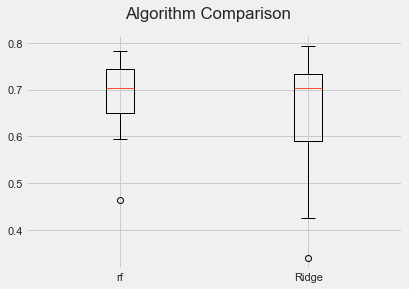

In [201]:
scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)


scaler.fit(X_train)
data = scaler.transform(data)

X = data
Y = target
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
# models.append(('LR', LinearRegression()))
models.append(('rf', RandomForestRegressor()))
models.append(('Ridge', Ridge()))

model_comparison(models)



## hacer escalado correctamente en train-test

## Data split

## Random forest

In [77]:
df3 = df.drop(['brand', 'Tm'], axis = 1)

In [78]:
y = df3['rating']
X = df3.drop('rating', axis = 1).copy() 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [79]:
X_train.shape, X_test.shape

((297, 52), (100, 52))

In [80]:
# model definition
rf = RandomForestRegressor(random_state = 0)

kfold = KFold(n_splits = 10)

scores = cross_val_score(rf, X, y, cv=kfold, verbose = 1, 
                         scoring = 'r2')
#                          scoring='neg_mean_absolute_error')

print("Cross-validation scores:\n{}".format(scores))
print("Number of cv iterations: ", len(scores))
print("Mean metric: {:.2f}".format(scores.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Cross-validation scores:
[0.48821572 0.60392407 0.61514606 0.78808174 0.70031898 0.70769463
 0.72275612 0.76709157 0.76820091 0.68089487]
Number of cv iterations:  10
Mean metric: 0.68


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.7s finished


In [94]:
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return rmse
    
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return rmse
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [93]:
cv(rf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Cross-validation scores:
[-0.00216432 -0.001247   -0.00145926 -0.00170081 -0.00139641 -0.0020932
 -0.00159435 -0.00121992 -0.00108997 -0.00201042]
Number of cv iterations:  10
Mean metric: -0.00


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.4s finished


In [55]:
rf_model = RandomForestRegressor(n_jobs=-1)
rf_model.fit(X_train, y_train)


rf_pred =  rf_model.predict(X_test)
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, rf_pred)))

Validation rmse: 3.192383122371123


## Linear model

In [62]:
lr_scaler = MinMaxScaler()
lr_scaler.fit(X_train)
X_train = lr_scaler.transform(X_train)
X_test = lr_scaler.transform(X_test)

lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(X_train, y_train)


lr_pred =  lr_model.predict(X_test)
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, lr_pred)))


Validation rmse: 3.522100911551761


## SVM

In [57]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

In [61]:
svr_rbf.fit(X_train, y_train)
svr_rbf_pred =  svr_rbf.predict(X_test)
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, svr_rbf_pred)))

Validation rmse: 3.0632340906512683
